# Plant Disease Detector

In [1]:
# Required libraries
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and PyTorch libraries for deep learning
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torchsummary import summary
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim

# Scikit-learn libraries for model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# OpenCV and PIL for image processing
import cv2
from PIL import Image
from IPython.display import clear_output

# Setting default size for plots
plt.rcParams["figure.figsize"] = (8, 6)

# Determine if CUDA is available and set the device accordingly
device = ("cuda" if torch.cuda.is_available() else "cpu")

## Extract Training Images from Files

In [2]:
# # Unzips folder containing plant disease data

# with zipfile.ZipFile("archive.zip","r") as zip_ref:
#    zip_ref.extractall("data/raw")

In [3]:
# # Extracts information from each file and puts them into a dataframe

# lst = os.listdir('./data/raw/archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/\
# train')
# lst.sort()
# df = pd.DataFrame(columns=['Image path', 'Type'])
# iterations = 0

# for item in lst:
#     path = './data/raw/archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
#     folder_path = os.path.join(path, item)
#     files = os.listdir(folder_path)
#     image_files = [file for file in files if file.lower().endswith('.jpg')]

#     for image_file in image_files:
#         image_path = os.path.join(folder_path, image_file)
#         df.loc[len(df)] = [image_path, item]
#         iterations += 1
        
#         if iterations % 10000 == 0:
#             print (str(iterations) + ' iterations...')

## Clean Dataframe

In [4]:
# # Assign New Labels

# lst2 = []
# dct = {}
# iteration = 0
# for i in lst:
#     name = i.split('___')[1]
#     if name not in lst2:
#         lst2.append(name)
#         dct[i] = iteration
#         iteration += 1
#     else:
#         num = lst2.index(name)
#         dct[i] = num

# def func1(name):
#     return dct[name]
# df['Label'] = df['Type'].apply(func1)

In [5]:
# # Creating Reduced Labels

# dct_reduced = dct.copy()
# for i in list(dct_reduced.keys()):
#     if 'spot' in i.lower():
#         if (i != 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)') & \
#             (i != 'Tomato___Spider_mites Two-spotted_spider_mite'):
#             dct_reduced[i] = 5
#     if 'blight' in i.lower():
#         dct_reduced[i] = 7
    
# for i in list(dct_reduced.keys()):
#     if dct_reduced[i] != 0:
#         if (dct_reduced[i] - 1) not in set(dct_reduced.values()):
#             while (dct_reduced[i] - 1) not in set(dct_reduced.values()):
#                 dct_reduced[i] = dct_reduced[i] - 1

In [6]:
# # Assigning Reduced Labels

# def func1(name):
#     return dct_reduced[name]
# df['New Label'] = df['Type'].apply(func1)

In [7]:
# # Save dataframe and csv

# df.to_csv('plant_disease.csv')

## Loading the Data

In [8]:
# Load and preprocess data
data1 = pd.read_csv('./plant_disease_valid.csv', index_col=[0]).drop(columns = 'Label')
data2 = pd.read_csv('./plant_disease_test.csv', index_col=[0])
data2 = data2.rename(columns={'Label': 'New Label'})
data3 = pd.read_csv('./plant_disease_train.csv', index_col=[0]).drop(columns = 'Label')

# Concatenate all data into a single DataFrame
total_data = pd.concat([data1, data2, data3], ignore_index=True)

# Splitting data into train, test, and validation sets
train_data, temp_test_data = train_test_split(total_data, test_size=0.4, random_state = 42, 
                                              stratify=total_data['New Label'])
test_data, validation_data = train_test_split(temp_test_data, test_size=0.5, random_state = 42, 
                                              stratify=temp_test_data['New Label'])

In [9]:
total_data

,Image path,Type,New Label
0,./data/raw/archive/New Plant Diseases Dataset(...,Apple___Apple_scab,0
1,./data/raw/archive/New Plant Diseases Dataset(...,Apple___Apple_scab,0
2,./data/raw/archive/New Plant Diseases Dataset(...,Apple___Apple_scab,0
3,./data/raw/archive/New Plant Diseases Dataset(...,Apple___Apple_scab,0
4,./data/raw/archive/New Plant Diseases Dataset(...,Apple___Apple_scab,0
...,...,...,...
89500,./data/raw/archive/New Plant Diseases Dataset(...,Tomato___healthy,3
89501,./data/raw/archive/New Plant Diseases Dataset(...,Tomato___healthy,3
89502,./data/raw/archive/New Plant Diseases Dataset(...,Tomato___healthy,3
89503,./data/raw/archive/New Plant Diseases Dataset(...,Tomato___healthy,3


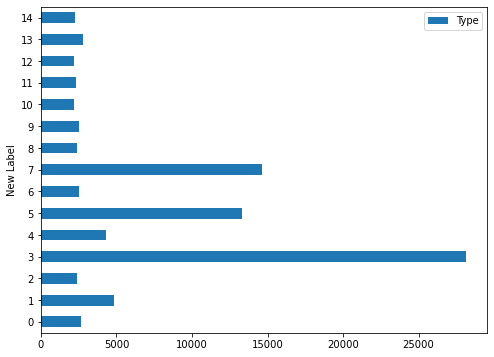

In [10]:
# Plotting bar graph of the counts of individual labels
total_data.groupby('New Label').count().get(['Type']).plot(kind='barh');

## Create a Dataset and Dataloader

In [11]:
# Define a custom dataset class

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['Image path']
        label = self.dataframe.iloc[idx]['New Label']
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        original_image = original_image.astype(np.float32) / 255.0
        
        if self.transform:
            transformed_image = self.transform(original_image)
        else:
            transformed_image = ToTensor()(original_image)

        return transformed_image, label

In [12]:
# Initialize datasets for train, validation, and test

dataset_train = CustomDataset(dataframe=train_data, transform=ToTensor())
dataset_validation = CustomDataset(dataframe=validation_data, transform=ToTensor())
dataset_test = CustomDataset(dataframe=test_data, transform=ToTensor())

In [13]:
# Initialize data loaders for batching

batch_size = 64
train_data_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, 
                               num_workers=4, pin_memory=True)
validation_data_loader = DataLoader(dataset=dataset_validation, batch_size=batch_size, shuffle=True,
                                    num_workers=4, pin_memory=True)
test_data_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, 
                                    num_workers=4, pin_memory=True)

In [14]:
# Function to display images

def show_images(images, labels):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i in range(num_images):
        image = images[i].squeeze().numpy()  # Squeeze to remove channel dimension for grayscale
        label = labels[i].item()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

In [15]:
# Check the shape of batch images

for batch_images, batch_labels in train_data_loader:
    print(batch_images[0].shape)
    break  # Display only the first batch

torch.Size([1, 256, 256])


## Neural Network

In [16]:
# Neural network architecture

class NeuralNet(nn.Module):
    def __init__(self, n_labels):
        super().__init__()

        # Layer definitions
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=2, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=2, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 64, kernel_size=2, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(4096 * 4, 1024)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024, n_labels)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu5(self.fc1(x)))
        x = self.fc2(x)
        
        return x

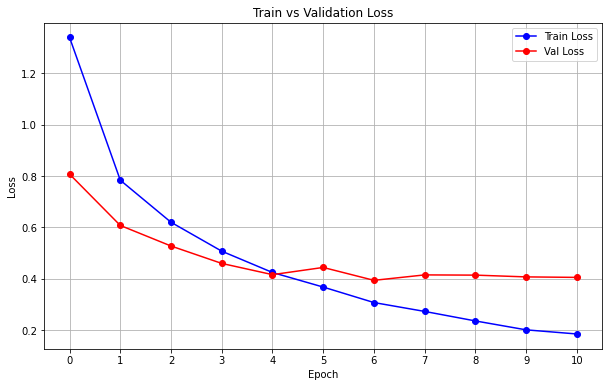

Epoch 11, Training Loss: 0.1851753125765494, Validation Loss: 0.4054362533081855


In [ ]:
# TRAINING LOOP WITH EARLY STOPPING

# Model setup
n_labels = 15
model = NeuralNet(n_labels).to(device)
model.float()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
patience = 5
best_val_loss = float('inf')
train_loss_values, val_loss_values = [], []
epochs_without_improvement = 0

# Training loop with early stopping
epoch = 0
while True:
    
    # Training phase
    model.train()
    total_train_loss = 0.0
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_loss_values.append(total_train_loss / len(train_data_loader))
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in validation_data_loader:
            val_inputs, val_labels = val_inputs.to(device, non_blocking=True), val_labels.to(device,
                                                                                             non_blocking=True)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()
    total_val_loss /= len(validation_data_loader)
    val_loss_values.append(total_val_loss)

    # Clear previous output and plot the training and validation loss
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_values, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.plot(val_loss_values, marker='o', linestyle='-', color='r', label='Val Loss')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.xticks(range(epoch + 1))
    plt.show()

    print(f"Epoch {epoch+1}, Training Loss: {train_loss_values[-1]}, Validation Loss: {val_loss_values[-1]}")
    
    # Check for improvement and save best model state
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_epoch = epoch
        best_model_state_dict = model.state_dict()
        print("Stored the best model's state dictionary in a variable.")
        epochs_without_improvement = 0
        print(f"Saved Best Model at Epoch {epoch+1}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.\
                  No improvement in validation loss for {patience} consecutive epochs.")
            break
    
    epoch += 1

print("Training complete")

In [ ]:
# Save the model

torch.save(model.state_dict(), 'best_model.pth')

## Testing

In [ ]:
# Bar graph of the counts of individual labels

test_data.groupby('New Label').count().get(['Type']).plot(kind='barh');

In [ ]:
# # Reload the Best Saved Model

# model_save_path = './best_model.pth'
# state_dict = torch.load(model_save_path)
# model = NeuralNet(15).to(device)
# model.float()
# model.load_state_dict(state_dict)

In [ ]:
model = model.to(device)
model.eval()

all_preds = []
all_labels = []

# Evaluation on test data
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and display accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate detailed classification report
print(classification_report(all_labels, all_preds))

In [ ]:
# Sample true labels and predicted labels
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

class_names = ['Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6',
               'Label 7', 'Label 8', 'Label 9', 'Label 10', 'Label 11', 'Label 12', 'Label 13', 'Label 14']

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()